In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from statsmodels.stats.outliers_influence import  OLSInfluence

In [3]:
from utilities import *

In [4]:
%matplotlib inline
plt.ioff()
sns.set()
pd.set_option('display.max_columns', 100)

# Part 1: Load the Data

In [5]:
def load_data():    
    df = pd.read_csv('dataset.csv')
    df.set_index(['class', 'id_student'],inplace = True)
    df['year'] = df.code_presentation.str.slice(0,4)
    df['semester'] = df.code_presentation.str.slice(4, 5)
    drop_col(df, 'code_presentation')
    return df

df = load_data()

In [6]:
# Mean imputation for SES
df.imd_band.fillna(df.imd_band.mean(), inplace = True)

In [7]:
# For our this modelling foray, we will juse use the assessment grade.
#  So drop any missing values
drop_by_rule(df, df.grade_Assessment.isna())
drop_col(df, 'grade_Exam')

In [8]:
df.head()

code_module  date_registration  grade_Assessment gender  \
class    id_student                                                           
AAA2013J 11391              AAA             -159.0              82.4      M   
         28400              AAA              -53.0              65.4      F   
         31604              AAA              -52.0              76.3      F   
         32885              AAA             -176.0              55.0      F   
         38053              AAA             -110.0              66.9      M   

                         highest_education  imd_band age_band  \
class    id_student                                             
AAA2013J 11391            HE Qualification      95.0     55<=   
         28400            HE Qualification      25.0    35-55   
         31604       A Level or Equivalent      55.0    35-55   
         32885          Lower Than A Level      55.0     0-35   
         38053       A Level or Equivalent      85.0    35-55   

                     num_of_prev_attempts  studied_credits disability  \
class    id_student                                                     
AAA2013J 11391                          0              240          N   
         28400                          0               60          N   
         31604                          0               60          N   
         32885                          0               60          N   
         38053                          0               60          N   

                     activity_skew  attention_chi_sq_gof  \
class    id_student                                        
AAA2013J 11391            0.741381              2.736682   
         28400            0.334122              0.763697   
         31604            0.256927              0.327877   
         32885            0.849391              2.519574   
         38053           -0.008823              0.338421   

                     attention_hellinger_squared  attention_total_variation  \
class    id_student                                                           
AAA2013J 11391                          0.385076                   0.401765   
         28400                          0.151137                   0.255698   
         31604                          0.124606                   0.200600   
         32885                          0.361038                   0.403652   
         38053                          0.098247                   0.195052   

                     clicks_dataplus  clicks_dualpane  clicks_externalquiz  \
class    id_student                                                          
AAA2013J 11391                   0.0              0.0                  0.0   
         28400                  10.0              0.0                  0.0   
         31604                   2.0              0.0                  0.0   
         32885                   0.0              0.0                  0.0   
         38053                   7.0              0.0                  0.0   

                     clicks_folder  clicks_forumng  clicks_glossary  \
class    id_student                                                   
AAA2013J 11391                 0.0           193.0              0.0   
         28400                 0.0           417.0              0.0   
         31604                 0.0           634.0              1.0   
         32885                 0.0           194.0              4.0   
         38053                 0.0           875.0              4.0   

                     clicks_homepage  clicks_htmlactivity  \
class    id_student                                         
AAA2013J 11391                 138.0                  0.0   
         28400                 324.0                  0.0   
         31604                 432.0                  0.0   
         32885                 204.0                  0.0   
         38053                 512.0                  0.0   

                     clicks_oucollaborate  clicks_

In [9]:
missing = df.isna().sum()
missing[missing != 0]

mean_click_time_from_release    2362
mean_click_time_to_close        2362
dtype: int64

In [10]:
y             = ['grade_Assessment']
X_categorical = ['code_module', 'year', 'semester', 'disability', 'gender', 'highest_education', 'age_band']
X_continuous  = df.columns.tolist()
for col in y + X_categorical:
    X_continuous.remove(col)
    
X_continuous.remove('num_materials_available')

# Part 2: Look at the Data

## Compare to the DV

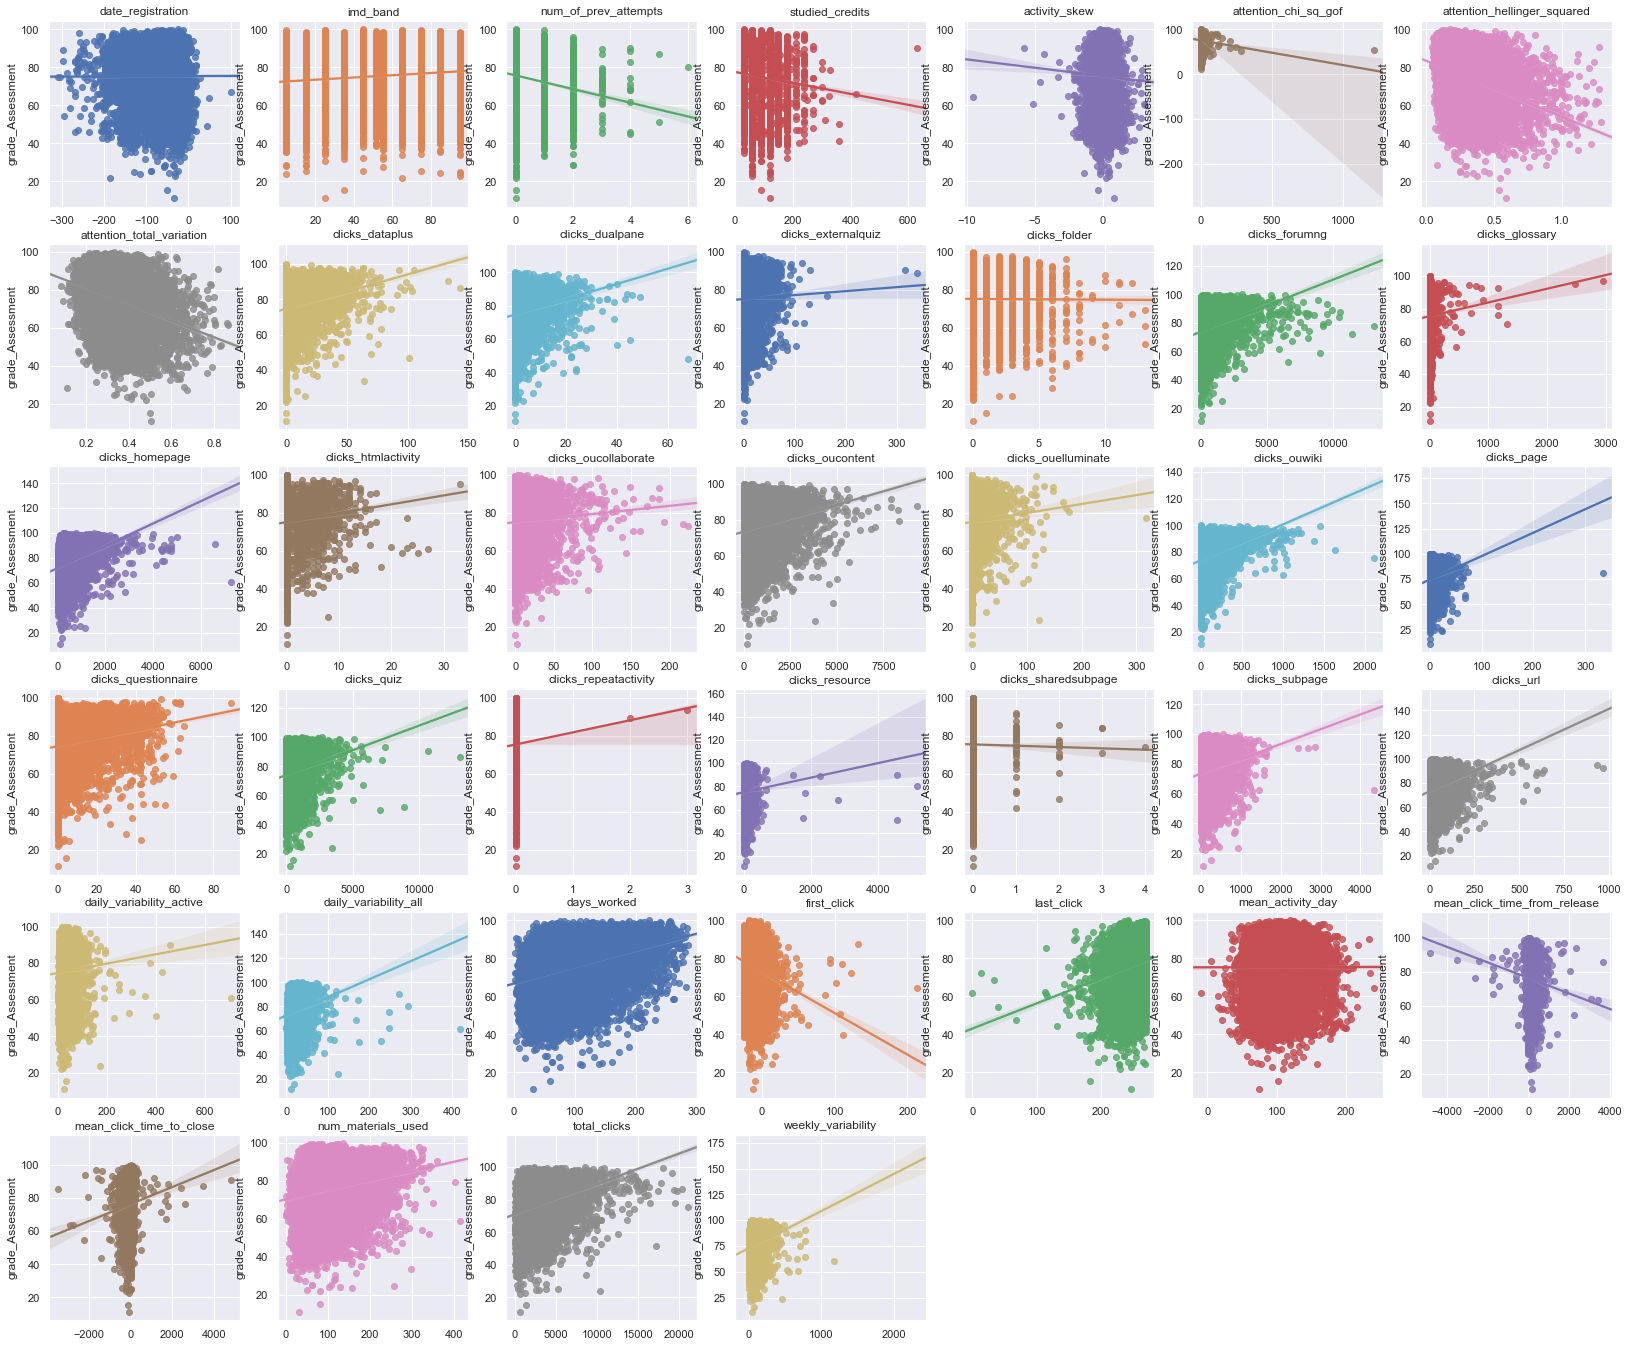

In [11]:
continuous_vars = FeaturePlot(df[X_continuous])

Timer.start()
for col_name, x, ax in continuous_vars:
    sns.regplot(x, df.grade_Assessment, x_ci = 95, ax = ax)

continuous_vars.fig

In [12]:
Timer.end()

47.347 seconds elapsed


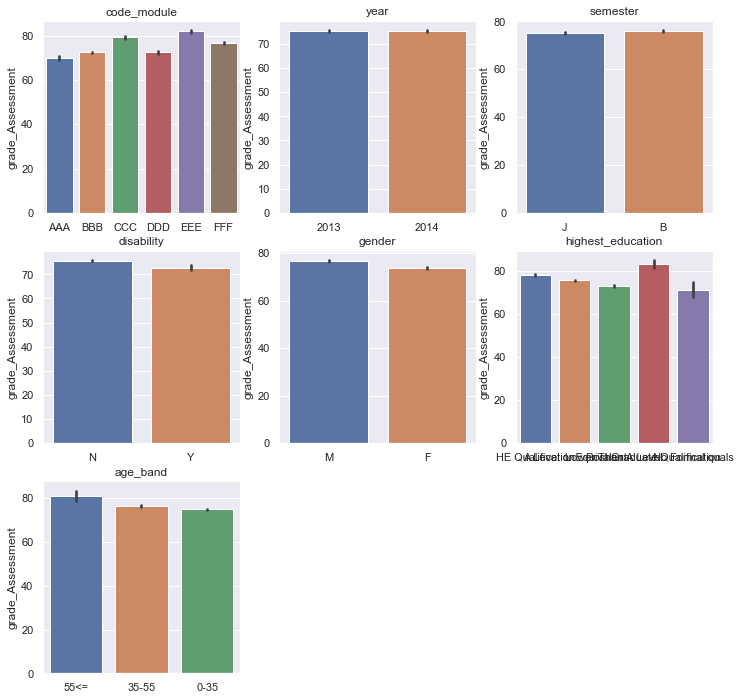

In [13]:
categorical_variables = FeaturePlot(df[X_categorical])

Timer.start()
for col_name, x, ax in categorical_variables:
    sns.barplot(x, df.grade_Assessment, ci = 95, ax = ax)

categorical_variables.fig

In [14]:
Timer.end()

3.130 seconds elapsed


In [15]:
# Make a table of Pearson Correlation coefficients
#  and p-values
#  Mathematically equivalent to Simple Linear Regression
#  (one co-variate)
results = []
for x in X_continuous:
    out_dict = {}
    data = df[[x, 'grade_Assessment']].dropna()
    r, p = st.pearsonr(data[x], data.grade_Assessment)
    out_dict['var'] = x
    out_dict['r'] = round(r, 3)
    out_dict['p'] = round(p, 3)
    out_dict['log_p'] = round(np.log(p)/np.log(10), 1)
    results.append(out_dict)

pearsonrs = pd.DataFrame.from_records(results).round(3)
pearsonrs.sort_values('log_p', inplace = True)
pearsonrs

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


,var,r,p,log_p
30,days_worked,0.347,0.000,-inf
6,attention_hellinger_squared,-0.363,0.000,-inf
7,attention_total_variation,-0.330,0.000,-315.8
37,total_clicks,0.287,0.000,-236.0
14,clicks_homepage,0.260,0.000,-191.8
19,clicks_ouwiki,0.249,0.000,-176.1
36,num_materials_used,0.216,0.000,-131.0
27,clicks_url,0.212,0.000,-126.4
12,clicks_forumng,0.212,0.000,-125.9
17,clicks_oucontent,0.189,0.000,-100.6


## Look at distributions

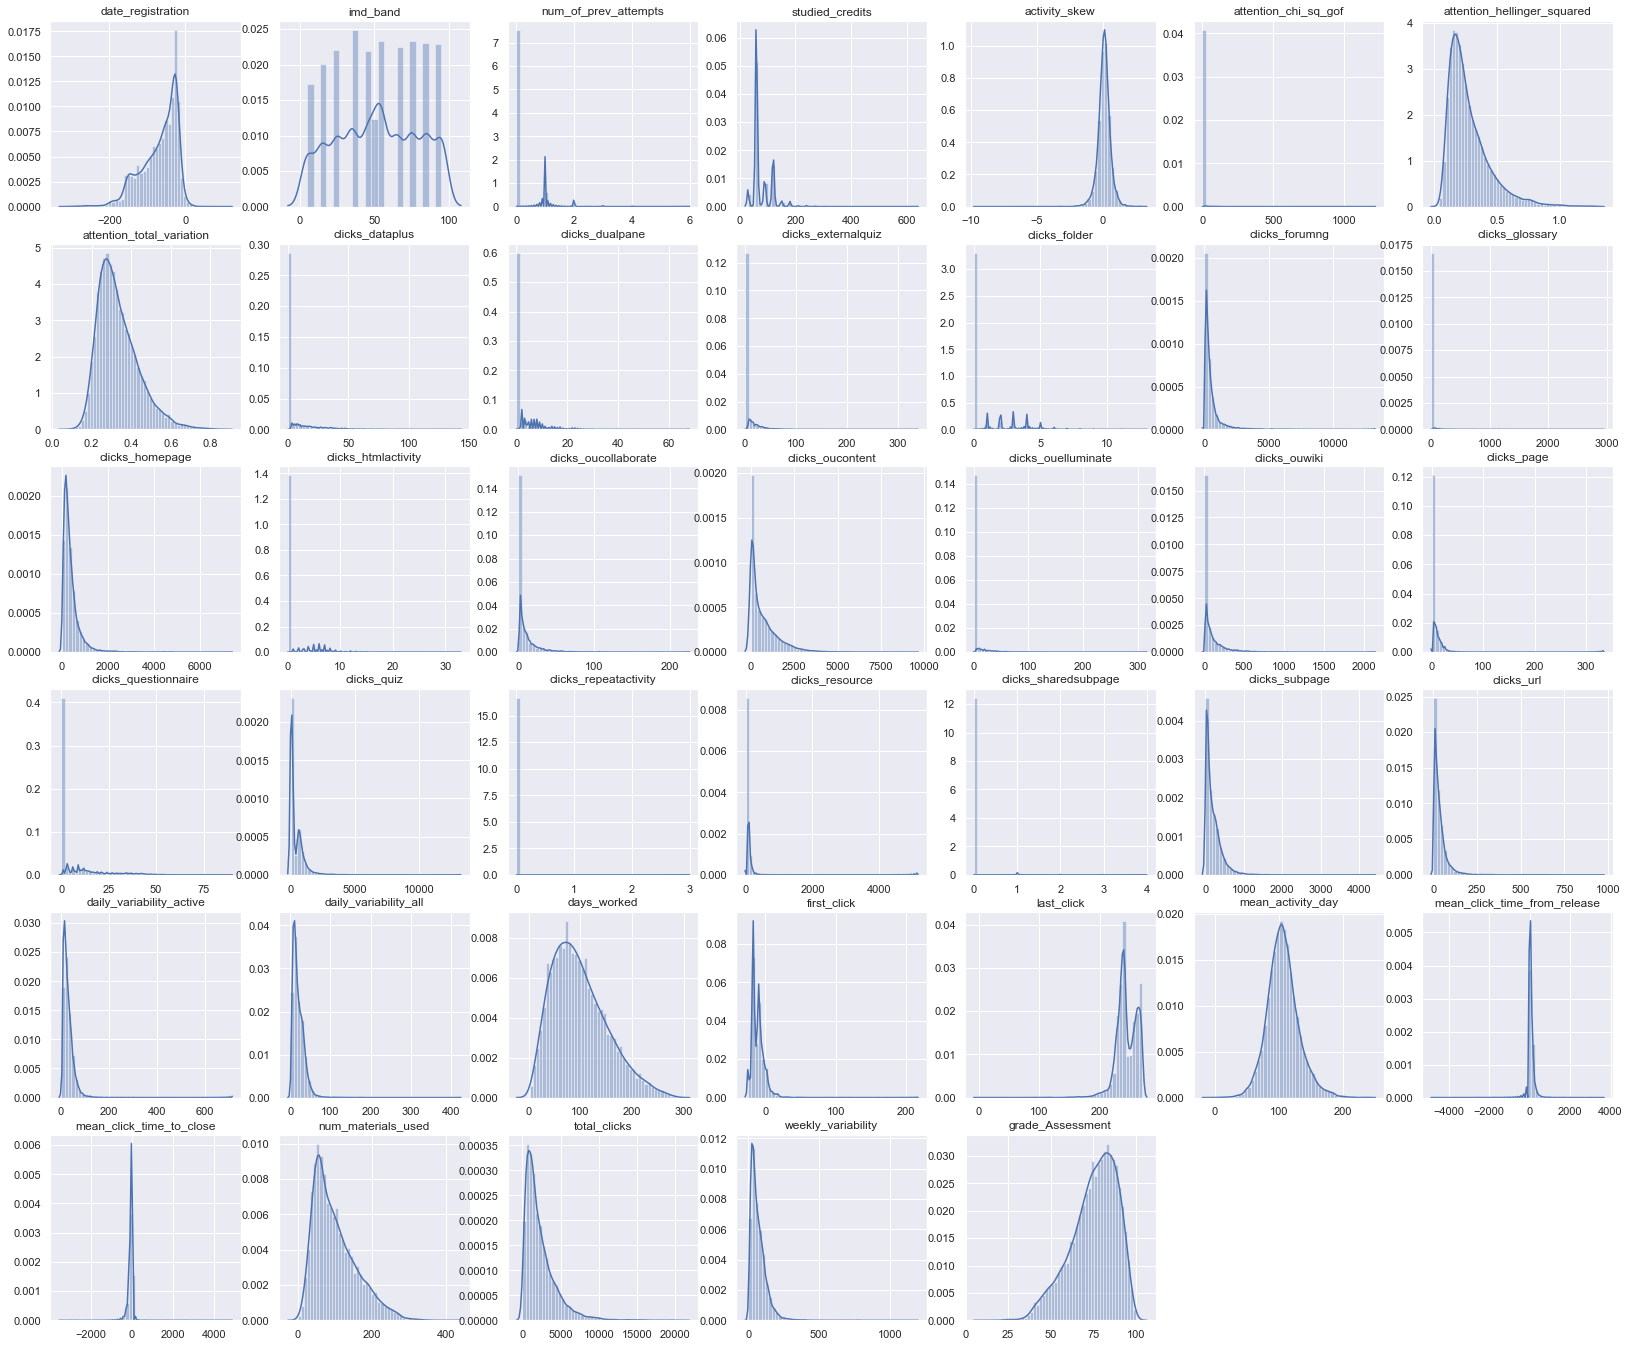

In [16]:
dists = FeaturePlot(df[X_continuous], df[y])

Timer.start()
for col_name, x, ax in dists:
    x = np.array(list(filter(lambda v : not pd.isnull(v), x)))
    sns.distplot(x, ax = ax)

dists.fig

In [17]:
Timer.end()

19.942 seconds elapsed


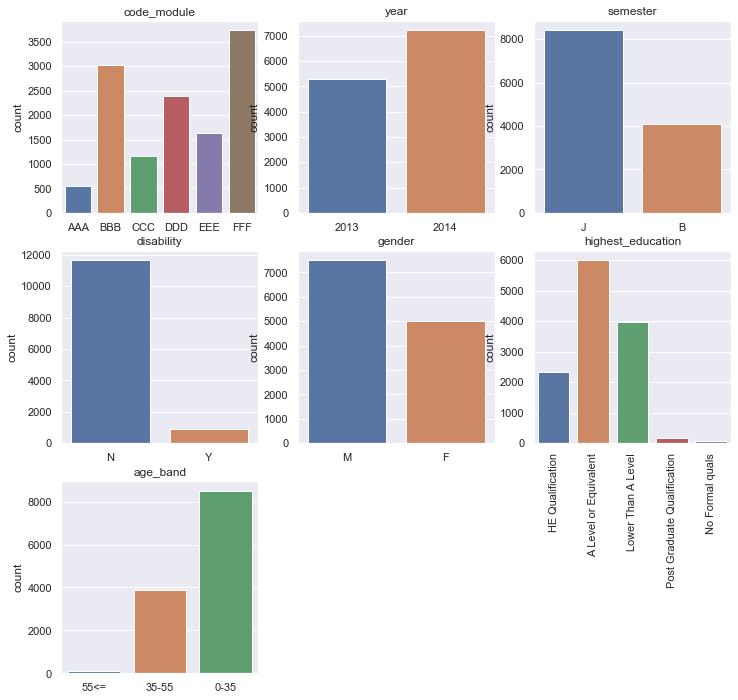

In [18]:
categorical_variables_dist = categorical_variables.clone()
for col, data, ax in categorical_variables_dist:
    sns.countplot(data, ax = ax)

labels = categorical_variables_dist.fig.axes[5].get_xticklabels()
for l in labels:
    l.set_rotation('vertical')
    
categorical_variables_dist.fig

In [19]:
# Age will create multi-collinearity problems so we recode the two highest age bands together
df.loc[:,'age_band'] = df.age_band.map(lambda band : {
    '55<=' : '35+',
    '35-55': '35+',
    '0-35' : '0-35'
}[band])

In [20]:
df.highest_education.value_counts()

A Level or Equivalent          5992
Lower Than A Level             3955
HE Qualification               2324
Post Graduate Qualification     177
No Formal quals                  65
Name: highest_education, dtype: int64

In [21]:
# So will education
# US Equivalents:
# A Level = High School Diploma/GED
# HE Qualification = Associates (approximately) or 'Some college'
df.loc[:,'highest_education'] = df.highest_education.map(lambda school : {
    'A Level or Equivalent'      : 'A Level or Equivalent',
    'Lower Than A Level'         : 'Lower than A Level',
    'HE Qualification'           : 'Some College or More',
    'Post Graduate Qualification': 'Some College or More',
    'No Formal quals'            : 'Lower than A Level'
}[school])

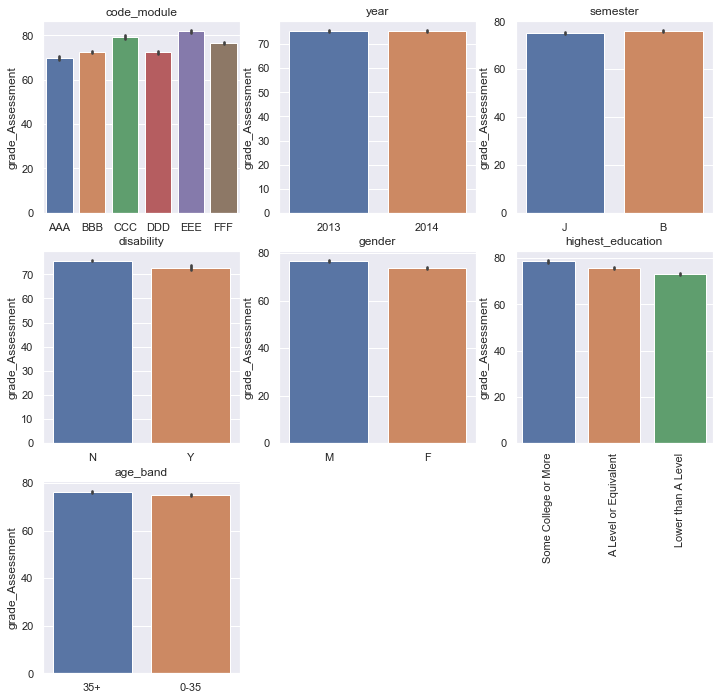

In [22]:
# Redo the distribution plot
categorical_variables_new = FeaturePlot(df[X_categorical])

Timer.start()
for col_name, x, ax in categorical_variables_new:
    sns.barplot(x, df.grade_Assessment, ci = 95, ax = ax)
    
labels = categorical_variables_new.fig.axes[5].get_xticklabels()
for l in labels:
    l.set_rotation('vertical')

categorical_variables_new.fig.savefig('cat_vars.svg')
categorical_variables_new.fig

# Part 3: Build a simple OLS model as a baseline
 - First, run a regression with everything
 - Second, do some simple feature selection

In [23]:
# The Model class is in utilities.py
#  It tracks which X and y variables are currently being used
#   as well as interactions and can generate formulas
#  It can also save and restore state
#  It has a simple wrapper around statsmodels OLS to run regressions
model = Model('grade_Assessment', X_categorical, X_continuous)
model.remove_var('total_clicks') # Otherwise perfect multi-collinearity

In [24]:
model.regress(df).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     82.64
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:56:32   Log-Likelihood:                -38767.
No. Observations:               10151   AIC:                         7.764e+04
Df Residuals:                   10100   BIC:                         7.801e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       63.3832      2.433     26.056      0.000      58.615      68.151
C(code_module)[T.BBB]                            5.5098      0.624      8.827      0.000       4.286       6.733
C(code_module)[T.CCC]                            9.3389      0.804     11.609      0.000       7.762      10.916
C(code_module)[T.DDD]                            0.3494      0.830      0.421      0.674      -1.277       1.976
C(code_module)[T.EEE]                            8.2539      0.715     11.545      0.000       6.852       9.655
C(code_module)[T.FFF]                            2.2533      0.753      2.991      0.003       0.776       3.730
C(year)[T.2014]                                 -0.6854      0.324     -2.117      0.034      -1.320      -0.051
C(semester)[T.J]                                -0.7700      0.359     -2.145      0.032      -1.473      -0.066
C(disability)[T.Y]                              -1.6552      0.444     -3.725      0.000      -2.526      -0.784
C(gender)[T.M]                                   0.8556      0.293      2.916      0.004       0.280       1.431
C(highest_education)[T.Lower than A Level]      -2.9755      0.253    -11.756      0.000      -3.472      -2.479
C(highest_education)[T.Some College or More]     0.9549      0.301      3.173      0.002       0.365       1.545
C(age_band)[T.35+]                              -0.9011      0.253     -3.565      0.000      -1.397      -0.406
date_registration                                0.0002      0.002      0.089      0.929      -0.005       0.005
imd_band                                         0.0419      0.004     10.286      0.000       0.034       0.050
num_of_prev_attempts                            -1.2307      0.291     -4.231      0.000      -1.801      -0.661
studied_credits                                 -0.0103      0.003     -3.048      0.002      -0.017      -0.004
activity_skew                                   -1.7690      0.553     -3.201      0.001      -2.852      -0.686
attention_chi_sq_gof                             0.0108      0.009      1.256      0.209      -0.006       0.028
attention_hellinger_squared                     -9.0846      2.647     -3.432      0.001     -14.274      -3.895
attention_total_variation                       -8.1770      3.920     -2.086      0.037     -15.860      -0.494
clicks_dataplus                                  0.0377      0.017      2.250      0.024       0.005       0.070
clicks_dualpane                                 -0.1045      0.038     -2.733      0.006      -0.180      -0.030
clicks_externalquiz                              0.1194      0.024      5.067      0.000       0.073       0.166
clicks_folder                   

## Analyze Missing Data
There is a substantial amount of non-randomly missing data in two columns, the mean click-time to close and open respectively. This is because some students never used material on which we can measure this.

In [25]:
df[['mean_click_time_from_release', 'mean_click_time_to_close']].isna().groupby('class').sum()

,mean_click_time_from_release,mean_click_time_to_close
class,,
AAA2013J,8.0,8.0
AAA2014J,11.0,11.0
BBB2013B,532.0,532.0
BBB2013J,21.0,21.0
BBB2014B,11.0,11.0
BBB2014J,6.0,6.0
CCC2014B,53.0,53.0
CCC2014J,91.0,91.0
DDD2013B,370.0,370.0


In [26]:
model.remove_var('mean_click_time_to_close', 'mean_click_time_from_release')

In [27]:
model.regress(df).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     99.69
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:56:33   Log-Likelihood:                -48163.
No. Observations:               12513   AIC:                         9.642e+04
Df Residuals:                   12464   BIC:                         9.679e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       65.9065      2.213     29.788      0.000      61.570      70.243
C(code_module)[T.BBB]                            5.9419      0.607      9.790      0.000       4.752       7.132
C(code_module)[T.CCC]                            8.5368      0.720     11.854      0.000       7.125       9.948
C(code_module)[T.DDD]                           -1.6800      0.672     -2.502      0.012      -2.996      -0.364
C(code_module)[T.EEE]                            8.0897      0.708     11.426      0.000       6.702       9.478
C(code_module)[T.FFF]                            2.9414      0.729      4.037      0.000       1.513       4.370
C(year)[T.2014]                                  0.0512      0.266      0.192      0.847      -0.470       0.572
C(semester)[T.J]                                -0.3110      0.305     -1.019      0.308      -0.909       0.287
C(disability)[T.Y]                              -1.6486      0.404     -4.077      0.000      -2.441      -0.856
C(gender)[T.M]                                   1.1142      0.263      4.242      0.000       0.599       1.629
C(highest_education)[T.Lower than A Level]      -3.0338      0.235    -12.891      0.000      -3.495      -2.572
C(highest_education)[T.Some College or More]     1.2326      0.279      4.410      0.000       0.685       1.780
C(age_band)[T.35+]                              -0.8318      0.235     -3.535      0.000      -1.293      -0.371
date_registration                                0.0017      0.002      0.784      0.433      -0.003       0.006
imd_band                                         0.0414      0.004     10.928      0.000       0.034       0.049
num_of_prev_attempts                            -1.2614      0.261     -4.838      0.000      -1.772      -0.750
studied_credits                                 -0.0087      0.003     -2.776      0.006      -0.015      -0.003
activity_skew                                   -2.6199      0.503     -5.214      0.000      -3.605      -1.635
attention_chi_sq_gof                             0.0165      0.009      1.896      0.058      -0.001       0.033
attention_hellinger_squared                    -14.2603      2.329     -6.122      0.000     -18.826      -9.695
attention_total_variation                        1.1595      3.438      0.337      0.736      -5.580       7.899
clicks_dataplus                                  0.0435      0.017      2.553      0.011       0.010       0.077
clicks_dualpane                                 -0.0560      0.038     -1.472      0.141      -0.131       0.019
clicks_externalquiz                              0.0404      0.014      2.961      0.003       0.014       0.067
clicks_folder                   

## Analyze the Categorical Variables

In [28]:
sm.stats.anova_lm(model.regress(df, include_cont = False),
                  typ = 2)

,sum_sq,df,F,PR(>F)
C(code_module),1.287711e+05,5.0,159.080439,1.952598e-164
C(year),2.536040e+03,1.0,15.664781,7.603758e-05
C(semester),1.161550e+03,1.0,7.174742,7.403380e-03
C(disability),2.614094e+03,1.0,16.146913,5.895746e-05
C(gender),5.572518e-01,1.0,0.003442,9.532166e-01
C(highest_education),3.535720e+04,2.0,109.198364,9.666783e-48
C(age_band),1.006361e+04,1.0,62.161584,3.425772e-15
Residual,2.023679e+06,12500.0,NaN,NaN


In [29]:
# Remove gender due to lack of signficance
model.remove_var('gender')
sm.stats.anova_lm(model.regress(df, include_cont = False),
                  typ = 2)

,sum_sq,df,F,PR(>F)
C(code_module),1.545633e+05,5.0,190.958636,1.131937e-196
C(year),2.536148e+03,1.0,15.666699,7.596057e-05
C(semester),1.161278e+03,1.0,7.173635,7.407946e-03
C(disability),2.614790e+03,1.0,16.152499,5.878405e-05
C(highest_education),3.539698e+04,2.0,109.329959,8.493373e-48
C(age_band),1.006408e+04,1.0,62.169422,3.412209e-15
Residual,2.023680e+06,12501.0,NaN,NaN


In [30]:
# Interactions
# Type 1 ANOVA table tests the signficance of including each variable 
#  after including *each previous variable*
formula = f'{model.y} ~ C(code_module)*C(semester)*C(year)'
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(code_module),5.0,1.543798e+05,30875.966538,188.713235,2.072295e-194
C(semester),1.0,1.299481e+03,1299.480548,7.942397,4.836571e-03
C(year),1.0,2.856662e+03,2856.661690,17.459854,2.954352e-05
C(code_module):C(semester),5.0,1.189350e+04,2378.699145,14.538557,3.103886e-14
C(code_module):C(year),5.0,1.276191e+04,2552.382882,15.600109,2.458566e-15
C(semester):C(year),1.0,3.003272e+02,300.327187,1.835593,1.754928e-01
C(code_module):C(semester):C(year),5.0,7.945613e+03,1589.122518,9.712682,2.840892e-09
Residual,12494.0,2.044183e+06,163.613149,NaN,NaN


In [31]:
# Every class instance appears to be different in its mean.
#  So we give up and return to just 'class' as a variable
#  Note: this is just reconstructing the class variable currently used as an index
df['class_'] = df[['code_module', 'semester', 'year']].apply(lambda l : ''.join(l), axis = 'columns')

model.remove_var('code_module', 'semester', 'year')
model.add_cat_var('class_')

In [32]:
# We can rule out interactions between the other categorical variables
formula = f'{model.y} ~ C(disability)*C(highest_education)*C(age_band)'
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(disability),1.0,6.520619e+03,6520.619474,37.442025,9.698642e-10
C(highest_education),2.0,4.450683e+04,22253.413334,127.781242,1.161305e-55
C(age_band),1.0,3.450691e+03,3450.691255,19.814201,8.608515e-06
C(disability):C(highest_education),2.0,1.488677e+03,744.338404,4.274063,1.394545e-02
C(disability):C(age_band),1.0,4.537473e+02,453.747328,2.605461,1.065214e-01
C(highest_education):C(age_band),2.0,9.665600e+02,483.279986,2.775040,6.238538e-02
C(disability):C(highest_education):C(age_band),2.0,2.220352e+02,111.017601,0.637474,5.286434e-01
Residual,12501.0,2.177079e+06,174.152426,NaN,NaN


In [33]:
# Look for interactions between these other variables and the class
formula = f'{model.y} ~ C(code_module)*(C(disability) + C(highest_education) + C(age_band))'
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(code_module),5.0,1.543798e+05,30875.966538,191.272323,5.606981e-197
C(disability),1.0,4.600600e+03,4600.599628,28.500076,9.533626e-08
C(highest_education),2.0,3.810061e+04,19050.307186,118.014006,1.681469e-51
C(age_band),1.0,1.021076e+04,10210.762146,63.254253,1.972733e-15
C(code_module):C(disability),5.0,1.237155e+03,247.431077,1.532801,1.758385e-01
C(code_module):C(highest_education),10.0,7.633670e+03,763.367004,4.728953,8.628224e-07
C(code_module):C(age_band),5.0,3.468707e+03,693.741485,4.297632,6.594157e-04
Residual,12483.0,2.015057e+06,161.424121,NaN,NaN


In [34]:
# It makes sense that the age and education response is different for different
#  classes (which presumably cover different subject matters)
model.add_interaction('C(code_module)', 'highest_education', sep = ':')
model.add_interaction('C(code_module)', 'age_band', sep = ':')

In [35]:
# This is our final choice for categorical variables
model.save_state('categorical_variables')

sm.stats.anova_lm(model.regress(df, include_cont = False),
                  typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(disability),1.0,6.520619e+03,6520.619474,41.069194,1.522217e-10
C(highest_education),2.0,4.450683e+04,22253.413334,140.159958,6.355167e-61
C(age_band),1.0,3.450691e+03,3450.691255,21.733688,3.164885e-06
C(class_),18.0,1.886303e+05,10479.459898,66.003387,7.071979e-230
C(code_module):C(highest_education),15.0,7.756289e+03,517.085960,3.256792,1.900748e-05
C(code_module):C(age_band),5.0,3.420795e+03,684.159080,4.309079,6.431787e-04
Residual,12475.0,1.980675e+06,158.771547,NaN,NaN


## Backwards Stepwise Selection for Continuous Variables
Remove the worst p-value above a threshold at each step

In [36]:
model.restore_state('categorical_variables')

In [37]:
# Backwards stepwise regression, but only on the continuous variables
def backwards_stepwise(model, df, pthresh = 0.05):
    results       = model.regress(df)
    pvalues       = results.pvalues
    relevant_vars = lfilter(lambda x : x in model.X_cont + model.get_continuous_interactions(), pvalues.index)
    pvalues       = pvalues[relevant_vars].sort_values(ascending = False)
    worst_p       = pvalues[0]
    if worst_p >= pthresh:
        model.remove_var(pvalues.index[0])
        print(f'Removing {pvalues.index[0]} with p = {pvalues.iloc[0]}')
        backwards_stepwise(model, df, pthresh = pthresh)

In [38]:
Timer.start()
backwards_stepwise(model, df, pthresh = 0.01)
Timer.end()

Removing clicks_dataplus with p = 0.9279331176070458
Removing clicks_questionnaire with p = 0.5487966477214957
Removing date_registration with p = 0.46826143919242846
Removing clicks_quiz with p = 0.46682989156717625
Removing clicks_homepage with p = 0.3919754088280589
Removing last_click with p = 0.3303576890239508
Removing first_click with p = 0.250504671636829
Removing clicks_htmlactivity with p = 0.14661011640822266
Removing attention_chi_sq_gof with p = 0.12887668126012636
Removing clicks_page with p = 0.07698918088862254
Removing clicks_repeatactivity with p = 0.078019531043467
Removing clicks_dualpane with p = 0.019495128129419198
Removing attention_hellinger_squared with p = 0.010862012421705139
6.154 seconds elapsed


In [39]:
model.save_state('backwards stepwise')
results = model.regress(df)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     88.10
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:56:44   Log-Likelihood:                -47982.
No. Observations:               12513   AIC:                         9.609e+04
Df Residuals:                   12452   BIC:                         9.654e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            70.8476      1.648     42.995      0.000      67.618      74.078
C(disability)[T.Y]                                                   -1.6381      0.399     -4.109      0.000      -2.420      -0.857
C(highest_education)[T.Lower than A Level]                           -1.2309      1.247     -0.987      0.324      -3.676       1.214
C(highest_education)[T.Some College or More]                          1.3977      1.144      1.222      0.222      -0.845       3.640
C(age_band)[T.35+]                                                   -0.6642      0.983     -0.676      0.499      -2.590       1.262
C(class_)[T.AAAJ2014]                                                 0.3893      0.958      0.406      0.685      -1.489       2.268
C(class_)[T.BBBB2013]                                                 4.6943      0.591      7.939      0.000       3.535       5.853
C(class_)[T.BBBB2014]                                                 4.9199      0.605      8.138      0.000       3.735       6.105
C(class_)[T.BBBJ2013]                                                 4.1841      0.541      7.735      0.000       3.124       5.244
C(class_)[T.BBBJ2014]                                                -2.7642      0.513     -5.387      0.000      -3.770      -1.758
C(class_)[T.CCCB2014]                                                 3.5198      0.710      4.956      0.000       2.128       4.912
C(class_)[T.CCCJ2014]                                                 5.8182      0.667      8.722      0.000       4.511       7.126
C(class_)[T.DDDB2013]                                                -4.5596      0.757     -6.022      0.000      -6.044      -3.076
C(class_)[T.DDDB2014]                                                -2.0830      0.647     -3.217      0.001      -3.352      -0.814
C(class_)[T.DDDJ2013]                                                -2.4409      0.562     -4.345      0.000      -3.542      -1.340
C(class_)[T.DDDJ2014]                                                 2.8413      0.556      5.109      0.000       1.751       3.931
C(class_)[T.EEEB2014]                                                 2.7688      0.702      3.945      0.000       1.393       4.145
C(class_)[T.EEEJ2013]                                                 3.6668      0.624      5.874      0.000       2.443       4.890
C(class_)[T.EEEJ2014]                                                 5.1819      0.611      8.481      0.000       3.984       6.380
C(class_)[T.FFFB2013]                                                -0.6962      0.611     -1.139      0.255      -1.894       0.502
C

## Look at how much the click granularity is useful

In [40]:
model.restore_state('backwards stepwise')

In [41]:
# It looks like the specific materials clicked on
#  are more important than just the total number of clicks

def is_click_var(var):
    return var.startswith('clicks_')
click_vars_in_model = filter(is_click_var, model.X_cont)

for var in click_vars_in_model:
    model.remove_var(var)
model.add_cont_var('total_clicks')
model.save_state('simple clicks')

model.regress(df).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     92.96
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:56:44   Log-Likelihood:                -48044.
No. Observations:               12513   AIC:                         9.620e+04
Df Residuals:                   12457   BIC:                         9.662e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            72.2671      1.644     43.970      0.000      69.046      75.489
C(disability)[T.Y]                                                   -1.5835      0.400     -3.955      0.000      -2.368      -0.799
C(highest_education)[T.Lower than A Level]                           -1.2397      1.253     -0.989      0.323      -3.696       1.217
C(highest_education)[T.Some College or More]                          1.5055      1.150      1.310      0.190      -0.748       3.759
C(age_band)[T.35+]                                                   -0.3365      0.986     -0.341      0.733      -2.270       1.597
C(class_)[T.AAAJ2014]                                                 0.3544      0.963      0.368      0.713      -1.533       2.242
C(class_)[T.BBBB2013]                                                 4.5069      0.593      7.605      0.000       3.345       5.669
C(class_)[T.BBBB2014]                                                 4.7600      0.607      7.837      0.000       3.569       5.951
C(class_)[T.BBBJ2013]                                                 3.9844      0.543      7.333      0.000       2.919       5.049
C(class_)[T.BBBJ2014]                                                -2.5652      0.510     -5.030      0.000      -3.565      -1.566
C(class_)[T.CCCB2014]                                                 3.0389      0.712      4.267      0.000       1.643       4.435
C(class_)[T.CCCJ2014]                                                 5.4064      0.669      8.083      0.000       4.095       6.718
C(class_)[T.DDDB2013]                                                -3.9550      0.689     -5.736      0.000      -5.306      -2.603
C(class_)[T.DDDB2014]                                                -2.3864      0.646     -3.692      0.000      -3.653      -1.119
C(class_)[T.DDDJ2013]                                                -2.5775      0.558     -4.619      0.000      -3.671      -1.484
C(class_)[T.DDDJ2014]                                                 2.6837      0.531      5.053      0.000       1.643       3.725
C(class_)[T.EEEB2014]                                                 2.8489      0.704      4.044      0.000       1.468       4.230
C(class_)[T.EEEJ2013]                                                 3.8653      0.627      6.169      0.000       2.637       5.094
C(class_)[T.EEEJ2014]                                                 5.2400      0.613      8.546      0.000       4.038       6.442
C(class_)[T.FFFB2013]                                                -1.1705      0.567     -2.065      0.039      -2.281      -0.059
C

In [42]:
model.restore_state('backwards stepwise')

# Part 4: Diagnosis the regression

## Deal with (multi)-collinearity

In [43]:
model.restore_state('backwards stepwise')
sns.set_style('white')
plt.close('all') # Prevent excessive memory use by doing this from time to time

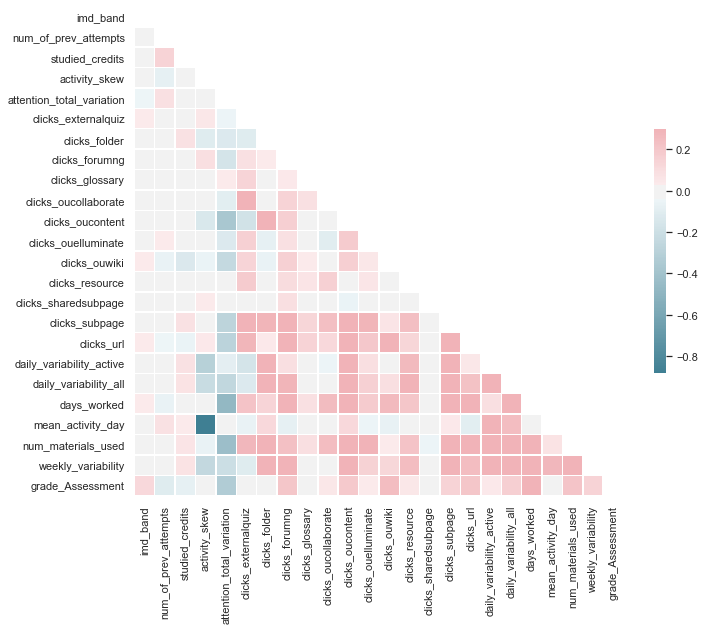

In [44]:
# The correlation matrix for the variables retained isn't too bad.
#  This is unsurprising since inflated p-values would have removed many variables
correlation_matrix(df[model.X_cont + [model.y]])

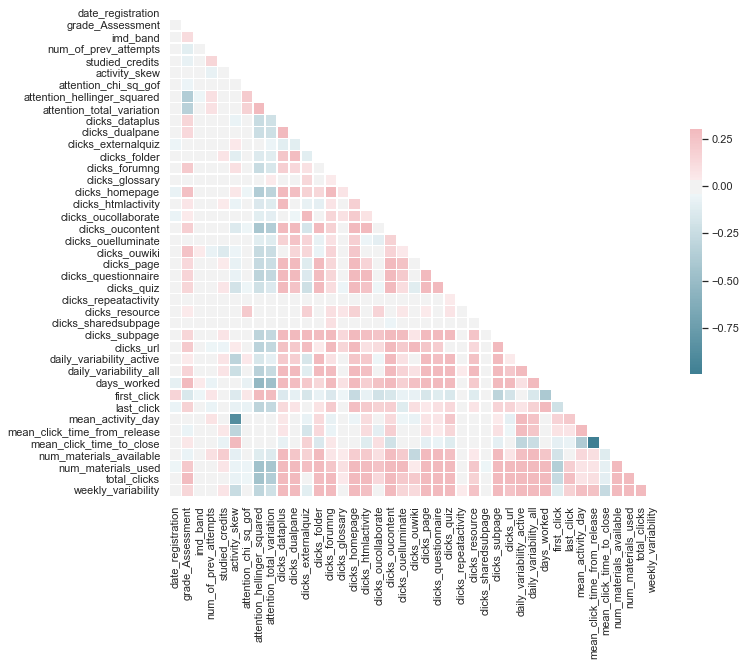

In [45]:
# Compare the full dataset. Also suprisingly not that bad
#  This is quite surprising since many of our features
#  are meant to be alternate measures of the same thing.
correlation_matrix(df)

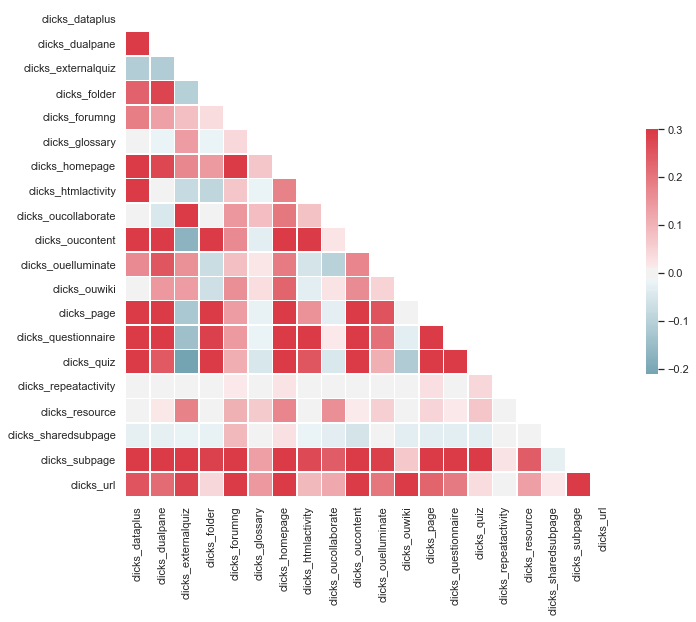

In [46]:
# also, it will behoove us to focus in on the clicks.
#  Note that many correlations are likely to be driven by
#  the different classes. (results not shown)
click_vars = lfilter(is_click_var, df.columns)
correlation_matrix(df[click_vars])

Finally, we will examine variance inflation factors

In [47]:
one_hot = pd.get_dummies(df[model.X_cont + model.X_cat], drop_first = True)

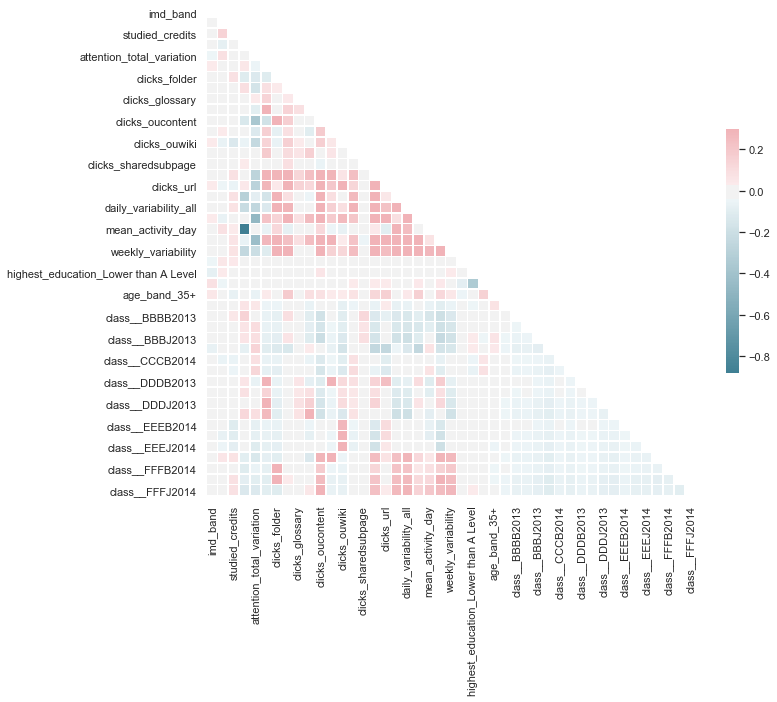

In [48]:
correlation_matrix(one_hot)

In [49]:
sns.set_style('darkgrid')

In [50]:
# vif_table is in utilities.py
# it is a wrapper for Statsmodels' variance_inflation_factor
# that produces an entire table and sorts it.
vif_table(one_hot)

daily_variability_all                     85.610033
mean_activity_day                         51.007171
daily_variability_active                  49.478527
weekly_variability                        33.610883
num_materials_used                        26.558963
days_worked                               19.364095
attention_total_variation                 16.028404
clicks_subpage                             9.030674
class__FFFJ2013                            7.389224
clicks_oucontent                           7.360852
studied_credits                            6.577271
class__FFFJ2014                            5.570789
class__FFFB2013                            4.835850
class__BBBJ2014                            4.765611
imd_band                                   4.597045
class__FFFB2014                            4.373650
class__DDDJ2014                            4.237158
class__DDDJ2013                            4.079589
clicks_folder                              3.801183
class__CCCJ2

In [51]:
# Only continuous variables will be dropped.
#  Returns a list of variables to drop
def drop_high_vif(df_one_hot, cont_var_list, vif_thresh = 10, verbose = True):
    to_drop = []
    df_one_hot    = df_one_hot.copy()
    cont_var_list = cont_var_list.copy()
    def recurse():
        table       = vif_table(df_one_hot)
        cont_table  = table[cont_var_list].sort_values(ascending = False)
        if cont_table[0] > vif_thresh:
            drop_var = cont_table.index[0]
            drop_col(df_one_hot, drop_var)
            cont_var_list.remove(drop_var)
            to_drop.append(drop_var)
            if verbose:
                print(f'Dropping {drop_var}')
            return recurse()
        else:
            return table
    
    table = recurse()
    
    return to_drop, df_one_hot, table
            

In [52]:
model.restore_state('backwards stepwise')

In [53]:
Timer.start()
to_drop, _, table = drop_high_vif(one_hot, model.X_cont)
Timer.end()

Dropping daily_variability_all
Dropping mean_activity_day
Dropping weekly_variability
Dropping num_materials_used
Dropping days_worked
Dropping attention_total_variation
17.815 seconds elapsed


In [54]:
table

clicks_subpage                            7.122579
studied_credits                           5.928553
daily_variability_active                  5.078322
clicks_oucontent                          4.770851
imd_band                                  4.317378
class__FFFJ2013                           4.286931
clicks_folder                             3.773389
clicks_url                                3.211654
clicks_ouwiki                             3.098219
class__FFFB2013                           2.962963
class__FFFJ2014                           2.948064
class__FFFB2014                           2.747935
clicks_externalquiz                       2.578086
class__DDDJ2014                           2.149691
class__EEEJ2014                           2.065604
class__BBBJ2014                           2.059141
class__DDDJ2013                           2.043126
class__EEEJ2013                           1.984685
class__DDDB2013                           1.980934
clicks_oucollaborate           

In [55]:
model.remove_var(*to_drop)
backwards_stepwise(model, df, pthresh = 0.01)
model.save_state('remove multicollinearity')

Removing clicks_ouelluminate with p = 0.13286759342092241
Removing clicks_sharedsubpage with p = 0.08752546743743407
Removing clicks_subpage with p = 0.05872372227478643
Removing studied_credits with p = 0.06000731788739547


In [56]:
results = model.regress(df)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     68.38
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:57:11   Log-Likelihood:                -48679.
No. Observations:               12513   AIC:                         9.746e+04
Df Residuals:                   12462   BIC:                         9.784e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            64.6008      1.031     62.668      0.000      62.580      66.621
C(disability)[T.Y]                                                   -1.5992      0.421     -3.803      0.000      -2.423      -0.775
C(highest_education)[T.Lower than A Level]                           -1.4200      1.318     -1.078      0.281      -4.003       1.163
C(highest_education)[T.Some College or More]                          1.4140      1.209      1.170      0.242      -0.956       3.784
C(age_band)[T.35+]                                                    0.3904      1.034      0.378      0.706      -1.636       2.417
C(class_)[T.AAAJ2014]                                                -0.4289      1.012     -0.424      0.672      -2.412       1.554
C(class_)[T.BBBB2013]                                                 5.1553      0.619      8.334      0.000       3.943       6.368
C(class_)[T.BBBB2014]                                                 4.3267      0.634      6.828      0.000       3.085       5.569
C(class_)[T.BBBJ2013]                                                 3.9126      0.568      6.884      0.000       2.799       5.027
C(class_)[T.BBBJ2014]                                                -1.9752      0.532     -3.713      0.000      -3.018      -0.933
C(class_)[T.CCCB2014]                                                 5.6886      0.739      7.696      0.000       4.240       7.138
C(class_)[T.CCCJ2014]                                                 7.5659      0.697     10.855      0.000       6.200       8.932
C(class_)[T.DDDB2013]                                                -0.3145      0.757     -0.415      0.678      -1.799       1.170
C(class_)[T.DDDB2014]                                                 0.3509      0.668      0.525      0.600      -0.959       1.661
C(class_)[T.DDDJ2013]                                                 0.0309      0.580      0.053      0.957      -1.105       1.167
C(class_)[T.DDDJ2014]                                                 2.0840      0.585      3.565      0.000       0.938       3.230
C(class_)[T.EEEB2014]                                                 3.2877      0.731      4.499      0.000       1.855       4.720
C(class_)[T.EEEJ2013]                                                 3.9782      0.654      6.087      0.000       2.697       5.259
C(class_)[T.EEEJ2014]                                                 5.9860      0.641      9.335      0.000       4.729       7.243
C(class_)[T.FFFB2013]                                                 2.7223      0.578      4.711      0.000       1.590       3.855
C

In [57]:
# Notice that our interaction terms have added some multi-collinearity
#  This is because patsy (the statsmodels formula package) doesn't know
#   that class instance (class_) is nested within class (code_module)
#  This messes up some of our coefficient estimates, 
#  and we can deal with it later when we look to interpret the final model.
#  But it won't affect other issues in the meantime
def design_matrix(results):
    return pd.DataFrame(results.model.exog, columns = results.params.index)

vif_table(design_matrix(results))

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


C(code_module)[T.FFF]:C(highest_education)[A Level or Equivalent]          inf
C(code_module)[T.BBB]:C(highest_education)[A Level or Equivalent]          inf
C(code_module)[T.DDD]:C(highest_education)[A Level or Equivalent]          inf
C(code_module)[T.EEE]:C(highest_education)[A Level or Equivalent]          inf
C(class_)[T.FFFJ2014]                                                      inf
C(code_module)[T.BBB]:C(highest_education)[Lower than A Level]             inf
C(code_module)[T.CCC]:C(highest_education)[Lower than A Level]             inf
C(code_module)[T.DDD]:C(highest_education)[Lower than A Level]             inf
C(code_module)[T.EEE]:C(highest_education)[Lower than A Level]             inf
C(code_module)[T.FFF]:C(highest_education)[Lower than A Level]             inf
C(code_module)[T.BBB]:C(highest_education)[Some College or More]           inf
C(code_module)[T.CCC]:C(highest_education)[Some College or More]           inf
C(code_module)[T.DDD]:C(highest_education)[Some Coll

## Residual diagnosis
Looking at the statistics in the regression summary above, we clearly have skewed residuals

In [58]:
model.restore_state('remove multicollinearity')
results = model.regress(df)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     68.38
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:57:15   Log-Likelihood:                -48679.
No. Observations:               12513   AIC:                         9.746e+04
Df Residuals:                   12462   BIC:                         9.784e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            64.6008      1.031     62.668      0.000      62.580      66.621
C(disability)[T.Y]                                                   -1.5992      0.421     -3.803      0.000      -2.423      -0.775
C(highest_education)[T.Lower than A Level]                           -1.4200      1.318     -1.078      0.281      -4.003       1.163
C(highest_education)[T.Some College or More]                          1.4140      1.209      1.170      0.242      -0.956       3.784
C(age_band)[T.35+]                                                    0.3904      1.034      0.378      0.706      -1.636       2.417
C(class_)[T.AAAJ2014]                                                -0.4289      1.012     -0.424      0.672      -2.412       1.554
C(class_)[T.BBBB2013]                                                 5.1553      0.619      8.334      0.000       3.943       6.368
C(class_)[T.BBBB2014]                                                 4.3267      0.634      6.828      0.000       3.085       5.569
C(class_)[T.BBBJ2013]                                                 3.9126      0.568      6.884      0.000       2.799       5.027
C(class_)[T.BBBJ2014]                                                -1.9752      0.532     -3.713      0.000      -3.018      -0.933
C(class_)[T.CCCB2014]                                                 5.6886      0.739      7.696      0.000       4.240       7.138
C(class_)[T.CCCJ2014]                                                 7.5659      0.697     10.855      0.000       6.200       8.932
C(class_)[T.DDDB2013]                                                -0.3145      0.757     -0.415      0.678      -1.799       1.170
C(class_)[T.DDDB2014]                                                 0.3509      0.668      0.525      0.600      -0.959       1.661
C(class_)[T.DDDJ2013]                                                 0.0309      0.580      0.053      0.957      -1.105       1.167
C(class_)[T.DDDJ2014]                                                 2.0840      0.585      3.565      0.000       0.938       3.230
C(class_)[T.EEEB2014]                                                 3.2877      0.731      4.499      0.000       1.855       4.720
C(class_)[T.EEEJ2013]                                                 3.9782      0.654      6.087      0.000       2.697       5.259
C(class_)[T.EEEJ2014]                                                 5.9860      0.641      9.335      0.000       4.729       7.243
C(class_)[T.FFFB2013]                                                 2.7223      0.578      4.711      0.000       1.590       3.855
C

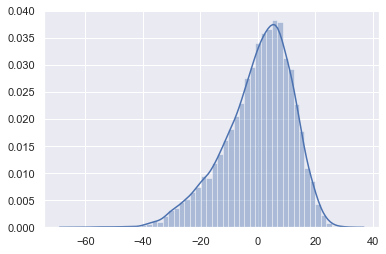

In [59]:
# Plot of the residuals clearly shows skew
plot(sns.distplot, results.resid)

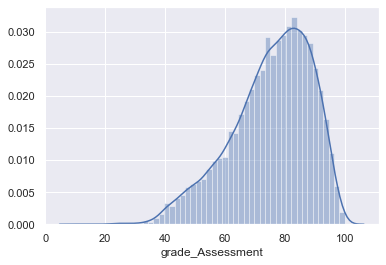

In [60]:
# Plot of the dependent variable suggests why that might be
plot(sns.distplot, df[model.y])

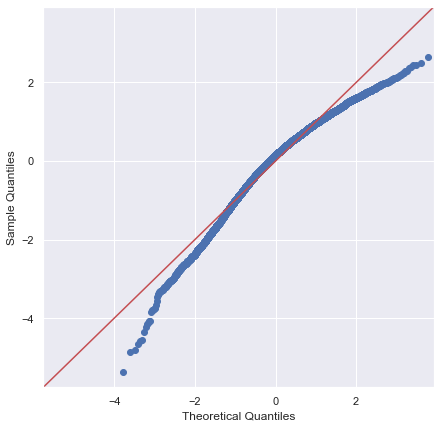

In [61]:
## QQ plot of the residuals
fig, ax = plt.subplots(figsize = (7, 7))
fig = sm.graphics.qqplot(results.resid, fit = True, line = '45', ax = ax)
fig.savefig('qqplot-before.png', transparent=True)
fig

In [62]:
# Box Cox transformation of the dependent variable
model.restore_state('remove multicollinearity')
df['grade_boxcox'], lambda_ = st.boxcox(df[model.y])
model.y = 'grade_boxcox'
model.save_state('y boxcox')
print(f'lambda = {round(lambda_,2)} in Box-Cox transformation')

lambda = 2.38 in Box-Cox transformation


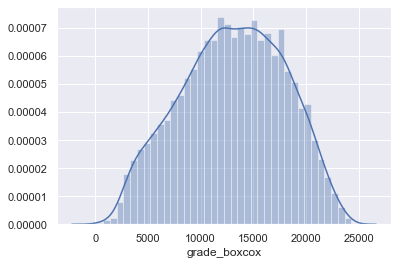

In [63]:
# After the transformation, the dependent variable looks less skewed
#  though the shape is now rather odd
plot(sns.distplot, df['grade_boxcox'])

In [64]:
# This leads to some improvement
results = model.regress(df)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           grade_boxcox   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     76.49
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:57:20   Log-Likelihood:            -1.2242e+05
No. Observations:               12513   AIC:                         2.449e+05
Df Residuals:                   12462   BIC:                         2.453e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          8835.6875    373.646     23.647      0.000    8103.284    9568.091
C(disability)[T.Y]                                                 -507.0897    152.434     -3.327      0.001    -805.884    -208.295
C(highest_education)[T.Lower than A Level]                         -447.9988    477.637     -0.938      0.348   -1384.242     488.244
C(highest_education)[T.Some College or More]                        459.1788    438.199      1.048      0.295    -399.759    1318.116
C(age_band)[T.35+]                                                  -20.7193    374.671     -0.055      0.956    -755.133     713.694
C(class_)[T.AAAJ2014]                                               -92.7412    366.751     -0.253      0.800    -811.629     626.147
C(class_)[T.BBBB2013]                                              1860.5092    224.202      8.298      0.000    1421.038    2299.981
C(class_)[T.BBBB2014]                                              1549.8453    229.674      6.748      0.000    1099.650    2000.041
C(class_)[T.BBBJ2013]                                              1323.3534    205.998      6.424      0.000     919.565    1727.142
C(class_)[T.BBBJ2014]                                              -614.1360    192.811     -3.185      0.001    -992.076    -236.196
C(class_)[T.CCCB2014]                                              2368.1201    267.926      8.839      0.000    1842.945    2893.295
C(class_)[T.CCCJ2014]                                              3133.1606    252.633     12.402      0.000    2637.961    3628.360
C(class_)[T.DDDB2013]                                               -47.0490    274.521     -0.171      0.864    -585.152     491.054
C(class_)[T.DDDB2014]                                               305.5462    242.234      1.261      0.207    -169.270     780.362
C(class_)[T.DDDJ2013]                                               133.9096    210.099      0.637      0.524    -277.917     545.736
C(class_)[T.DDDJ2014]                                               992.2676    211.897      4.683      0.000     576.917    1407.618
C(class_)[T.EEEB2014]                                              1224.6368    264.874      4.623      0.000     705.444    1743.830
C(class_)[T.EEEJ2013]                                              1534.3809    236.904      6.477      0.000    1070.013    1998.748
C(class_)[T.EEEJ2014]                                              2330.0391    232.427     10.025      0.000    1874.446    2785.632
C(class_)[T.FFFB2013]                                              1060.7477    209.443      5.065      0.000     650.206    1471.289
C

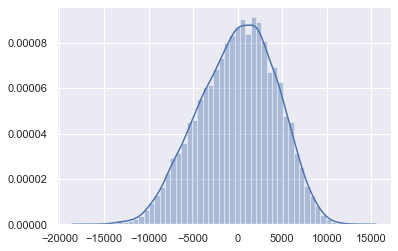

In [65]:
# Residual plot is clearly better
plot(sns.distplot, results.resid)

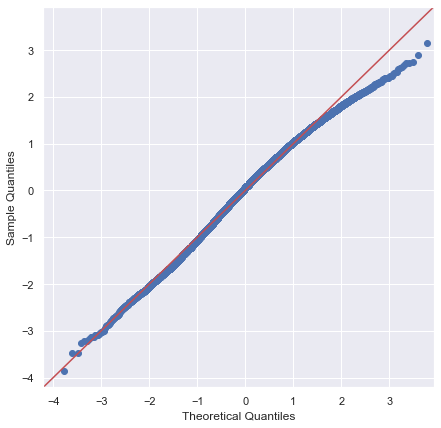

In [66]:
# So is the QQ plot
fig, ax = plt.subplots(figsize = (7, 7))
fig = sm.graphics.qqplot(results.resid, fit = True, line = '45', ax = ax)
fig.savefig('qqplot-after.png', transparent = True)
fig

In [67]:
# Re-run the model selection process
#  with the alternative (transformed) DV
#  specification.
#
#  Results: exactly the same variables stay signficant
model.restore_state('categorical_variables')
model.y = 'grade_boxcox'

backwards_stepwise(model, df, pthresh = 0.01)
print('Done with backwards stepwise')
one_hot = pd.get_dummies(df[model.X_cont + model.X_cat], drop_first = True)
to_drop, _, _ = drop_high_vif(one_hot, model.X_cont)
model.remove_var(*to_drop)
print('Done with high VIF')
backwards_stepwise(model, df, pthresh = 0.01)
print('Done with backwards stepwise part 2')

model.save_state('y boxcox full process')
model.regress(df).summary()

Removing clicks_questionnaire with p = 0.9112807587572733
Removing clicks_dataplus with p = 0.8308539810276149
Removing last_click with p = 0.372309555298581
Removing first_click with p = 0.26582793228462365
Removing date_registration with p = 0.23582069728580166
Removing clicks_page with p = 0.18090202070628986
Removing clicks_homepage with p = 0.17390832766290296
Removing clicks_quiz with p = 0.19162404070739641
Removing attention_chi_sq_gof with p = 0.12811168224925407
Removing clicks_htmlactivity with p = 0.09580539764971563
Removing clicks_repeatactivity with p = 0.04563084087163296
Removing attention_hellinger_squared with p = 0.038229693475515886
Removing clicks_dualpane with p = 0.013369620201551776
Done with backwards stepwise
Dropping daily_variability_all
Dropping mean_activity_day
Dropping weekly_variability
Dropping num_materials_used
Dropping days_worked
Dropping attention_total_variation
Done with high VIF
Removing clicks_ouelluminate with p = 0.143012663916778
Removing 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           grade_boxcox   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     76.49
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:57:50   Log-Likelihood:            -1.2242e+05
No. Observations:               12513   AIC:                         2.449e+05
Df Residuals:                   12462   BIC:                         2.453e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          8835.6875    373.646     23.647      0.000    8103.284    9568.091
C(disability)[T.Y]                                                 -507.0897    152.434     -3.327      0.001    -805.884    -208.295
C(highest_education)[T.Lower than A Level]                         -447.9988    477.637     -0.938      0.348   -1384.242     488.244
C(highest_education)[T.Some College or More]                        459.1788    438.199      1.048      0.295    -399.759    1318.116
C(age_band)[T.35+]                                                  -20.7193    374.671     -0.055      0.956    -755.133     713.694
C(class_)[T.AAAJ2014]                                               -92.7412    366.751     -0.253      0.800    -811.629     626.147
C(class_)[T.BBBB2013]                                              1860.5092    224.202      8.298      0.000    1421.038    2299.981
C(class_)[T.BBBB2014]                                              1549.8453    229.674      6.748      0.000    1099.650    2000.041
C(class_)[T.BBBJ2013]                                              1323.3534    205.998      6.424      0.000     919.565    1727.142
C(class_)[T.BBBJ2014]                                              -614.1360    192.811     -3.185      0.001    -992.076    -236.196
C(class_)[T.CCCB2014]                                              2368.1201    267.926      8.839      0.000    1842.945    2893.295
C(class_)[T.CCCJ2014]                                              3133.1606    252.633     12.402      0.000    2637.961    3628.360
C(class_)[T.DDDB2013]                                               -47.0490    274.521     -0.171      0.864    -585.152     491.054
C(class_)[T.DDDB2014]                                               305.5462    242.234      1.261      0.207    -169.270     780.362
C(class_)[T.DDDJ2013]                                               133.9096    210.099      0.637      0.524    -277.917     545.736
C(class_)[T.DDDJ2014]                                               992.2676    211.897      4.683      0.000     576.917    1407.618
C(class_)[T.EEEB2014]                                              1224.6368    264.874      4.623      0.000     705.444    1743.830
C(class_)[T.EEEJ2013]                                              1534.3809    236.904      6.477      0.000    1070.013    1998.748
C(class_)[T.EEEJ2014]                                              2330.0391    232.427     10.025      0.000    1874.446    2785.632
C(class_)[T.FFFB2013]                                              1060.7477    209.443      5.065      0.000     650.206    1471.289
C

In [68]:
# Model is very hard to interpret, so go back to the main model
model.restore_state('remove multicollinearity')

In [69]:
# For publication-ready figures
var_name_dict = {
    'imd_band'                    : 'Residence SES',
    'num_of_prev_attempts'        : 'Previous Attempts',
    'activity_skew'               : 'Activity Skew',
    'daily_variability_active'    : 'Activity Variability',
    'clicks_externalquiz'         : 'Clicks: External Quiz',
    'clicks_folder'               : 'Clicks: Folder',
    'clicks_forumng'              : 'Clicks: Forum',
    'clicks_glossary'             : 'Clicks: Glossary',
    'clicks_oucollaborate'        : 'Clicks: Collaboration Material',
    'clicks_oucontent'            : 'Clicks: University Content',
    'clicks_ouwiki'               : 'Clicks: University Wiki',
    'clicks_resource'             : 'Clicks: Resource',
    'clicks_url'                  : 'Clicks: URL',
    'disability'                  : 'Disability',
    'highest_education'           : 'Prior Education',
    'age_band'                    : 'Age',
    'class_'                      : 'Class Instance'
}

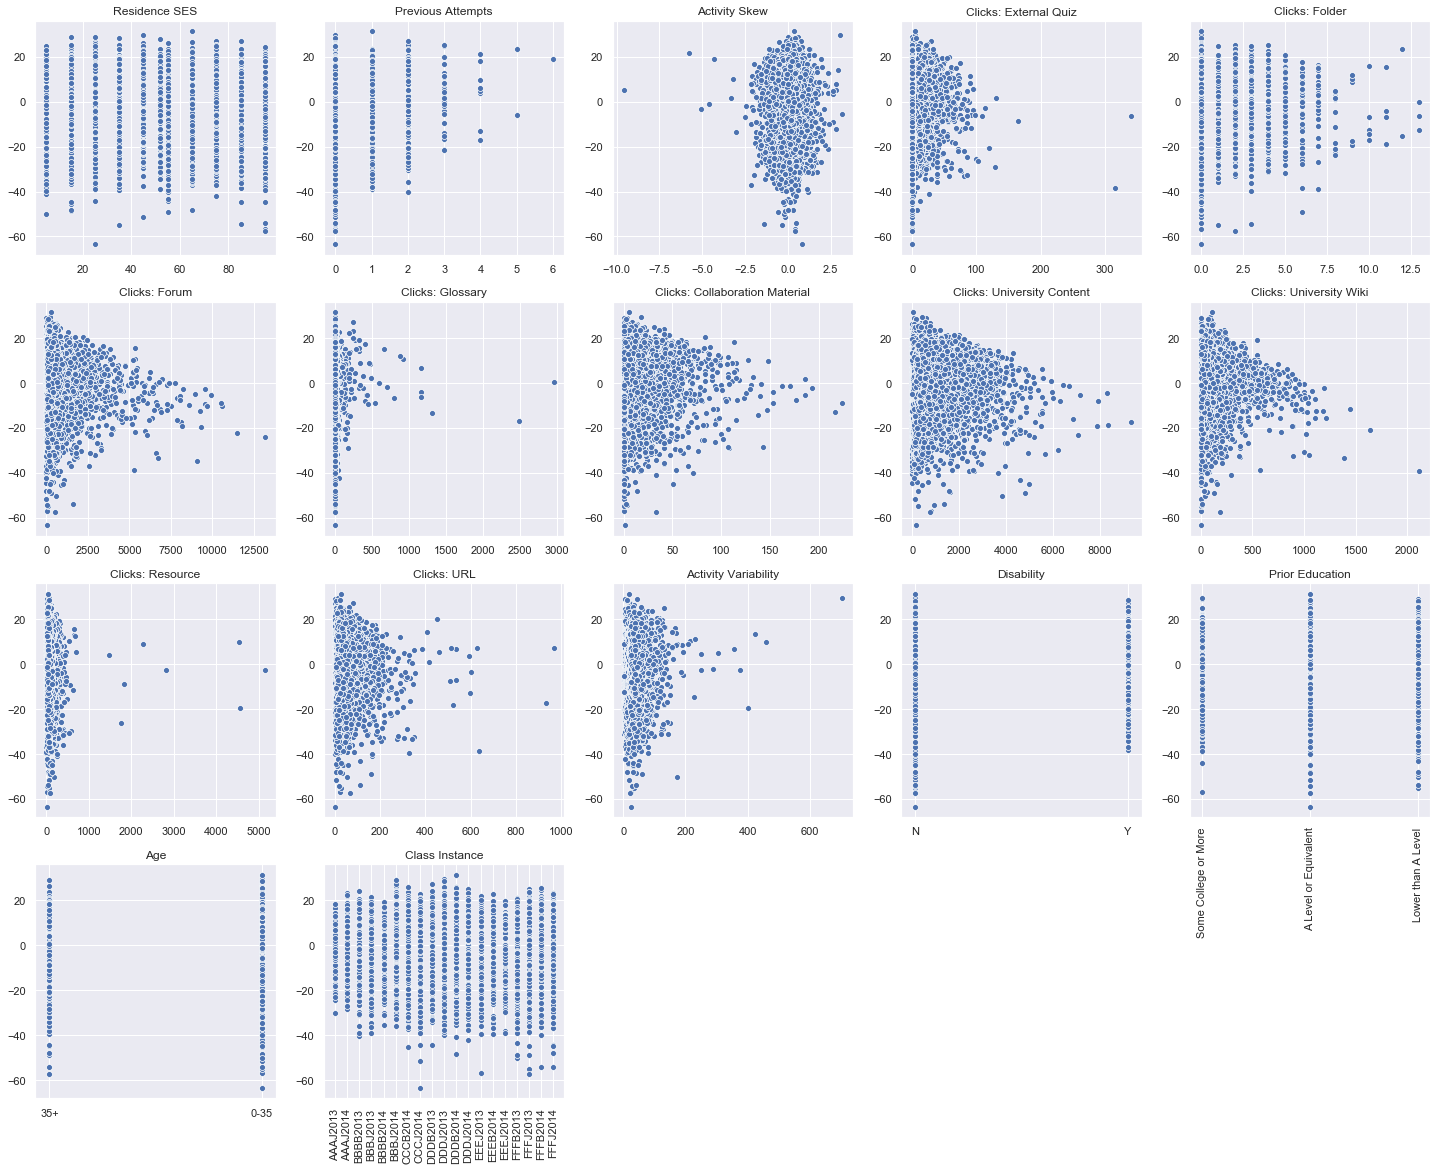

In [70]:
# Create residual plots for publication
#  Linearity looks okay; heteroskedasticity is a problem
#
#  Commented out: comparison with residuals using the box-cox transformed DV
#   this doesn't show much visual difference
model.restore_state('remove multicollinearity')
results_model = model.regress(df)

resid_plot = FeaturePlot(df[model.X_cont + model.X_cat], axsize = 5)

for col, data, ax in resid_plot:
    sns.scatterplot(data, results_model.resid, ax = ax)
    if col in var_name_dict:
        ax.set_title(var_name_dict[col])
    else:
        print(f'Missing {col} in renaming dict')
    if col in ['highest_education', 'class_']:
        labels = ax.get_xticklabels()
        for l in labels:
            l.set_rotation('vertical')

resid_plot.fig.savefig('residual-plot.png', transparent = True)

resid_plot.fig

In [71]:
# Breusch Pagan test for Heteroskedasticity
# The first pair is Chi2 with (p-1) df where p = 17 and a p-value.
# The second pair is an F score and its p-value
sm.stats.diagnostic.het_breuschpagan(results_model.resid, df[model.X_cont])

(3180.968148462011, 0.0, 327.7553343509994, 0.0)

In [72]:
# Heteroskedasticity got worse with a transformed DV
model.restore_state('y boxcox')
results_boxcox = model.regress(df)
model.restore_state('remove multicollinearity')
sm.stats.diagnostic.het_breuschpagan(results_boxcox.resid, df[model.X_cont])

(4262.172644637055, 0.0, 496.7069059894725, 0.0)

In [73]:
# Heteroskedasticity Robust Standard Errors (HC0) show no loss of signficance
(results_model.params/results_model.HC0_se).map(lambda t : st.norm.sf(np.abs(t)))

Intercept                                                            0.000000e+00
C(disability)[T.Y]                                                   2.295656e-04
C(highest_education)[T.Lower than A Level]                           1.006096e-01
C(highest_education)[T.Some College or More]                         6.816912e-02
C(age_band)[T.35+]                                                   3.235323e-01
C(class_)[T.AAAJ2014]                                                3.032529e-01
C(class_)[T.BBBB2013]                                                1.054427e-22
C(class_)[T.BBBB2014]                                                2.594802e-16
C(class_)[T.BBBJ2013]                                                1.599083e-17
C(class_)[T.BBBJ2014]                                                1.334887e-05
C(class_)[T.CCCB2014]                                                1.191721e-13
C(class_)[T.CCCJ2014]                                                1.322773e-28
C(class_)[T.DDDB

In [74]:
# As an attempt to fix heteroskedasticity,
# we can attempt to transform the regressors too

# We can try this both with and without a transformed DV
#  Results are qualitatively similar
model.restore_state('remove multicollinearity')
# model.restore_state('y boxcox')
for var in model.X_cont.copy():
    try:
        new_name = var + '_boxcox'
        if var.startswith('clicks_'):
            shift = 1
        else:
            shift = 0
        df[new_name], lambda_ = st.boxcox(df[var] + shift)
        print(f'lambda = {lambda_} for {var}')
        model.remove_var(var)
        model.add_cont_var(new_name)
    except ValueError:
        print(f'Unable to transform {var}')
        
model.save_state('x boxcox')

lambda = 0.7923942650798255 for imd_band
Unable to transform num_of_prev_attempts
Unable to transform activity_skew
lambda = -1.9830722455084087 for clicks_externalquiz
lambda = -5.5485661452679205 for clicks_folder
lambda = 0.17207094309677234 for clicks_forumng
lambda = -1.8084548987699594 for clicks_glossary
lambda = -0.4252057613294365 for clicks_oucollaborate
lambda = 0.23081959592176576 for clicks_oucontent
lambda = -0.16397541224474171 for clicks_ouwiki
lambda = 0.1048321635319503 for clicks_resource
lambda = 0.15804066046930892 for clicks_url
lambda = -0.007813282275591762 for daily_variability_active


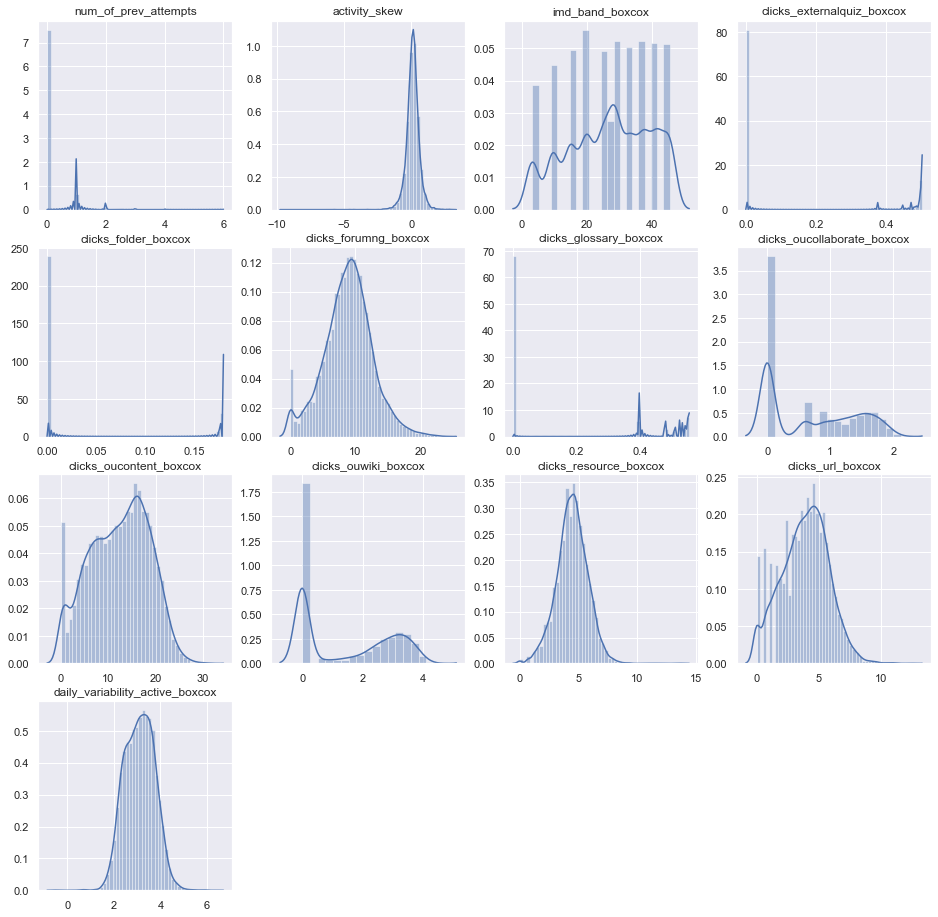

In [75]:
boxcox_plot = FeaturePlot(df[model.X_cont])
for col, data, ax in boxcox_plot:
    sns.distplot(data, ax = ax)
boxcox_plot.fig

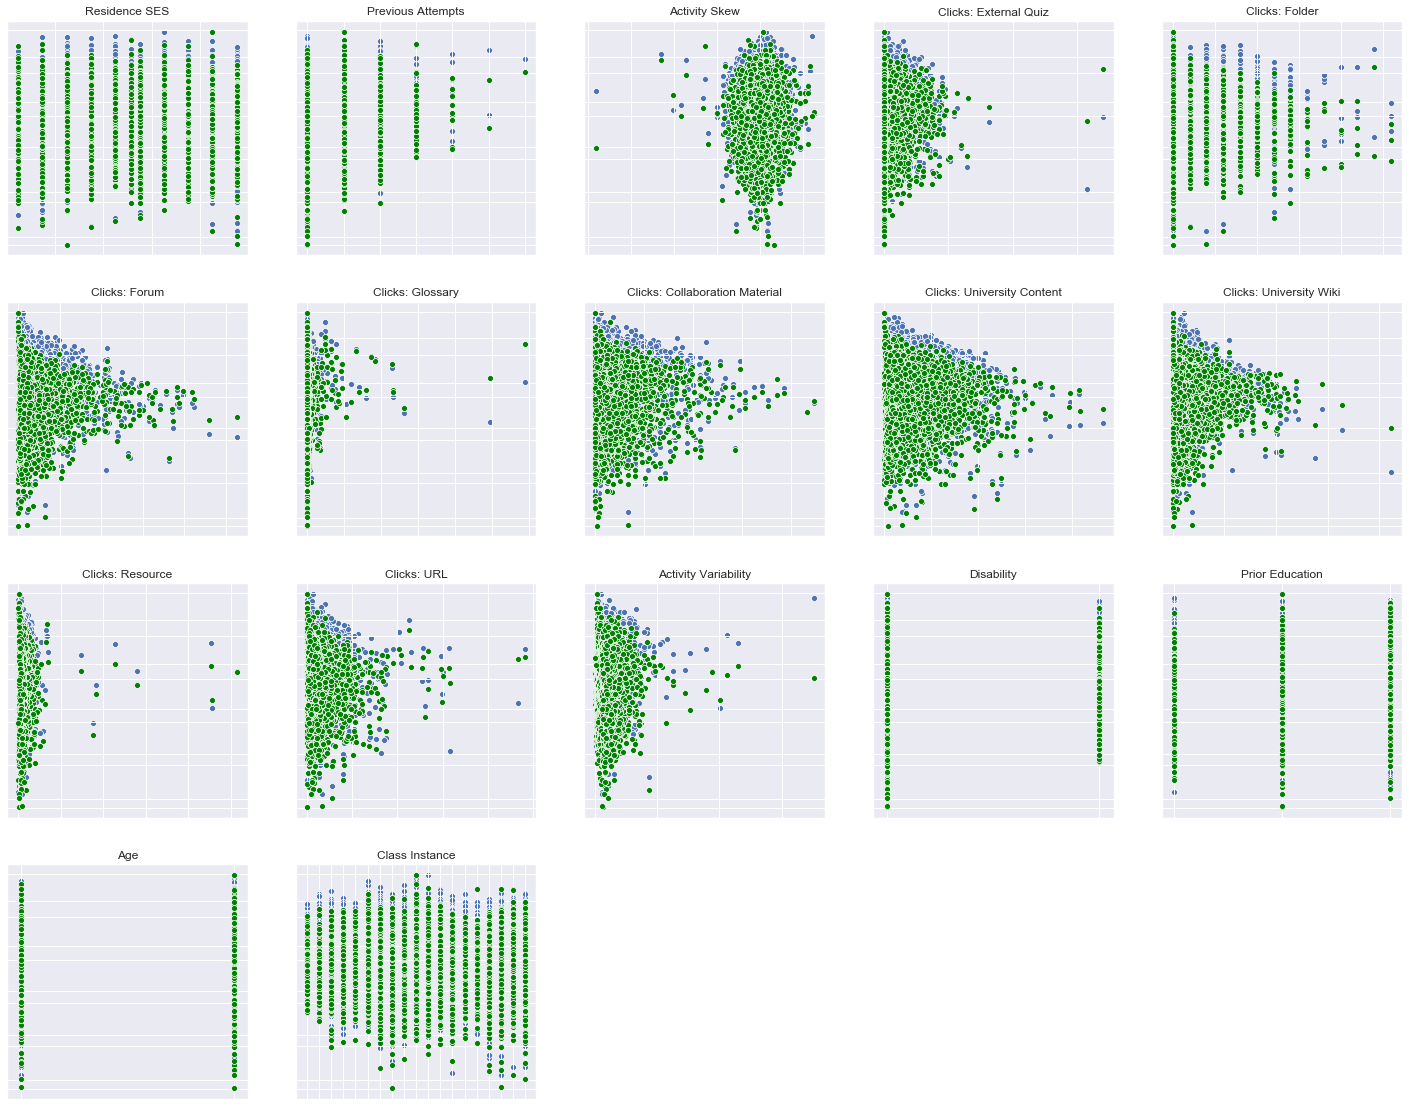

In [76]:
# But not much
results = model.regress(df)
for col, data, ax in resid_plot.overlay('transform IV'):
    sns.scatterplot(data, results.resid, ax = ax, color = 'green')

resid_plot.fig

In [77]:
# Breusch Pagan test for Heteroskedasticity
# The third result is an f score. 2nd and 4th are p-values indistinguishable from 0

# It appears things actually got worse
sm.stats.diagnostic.het_breuschpagan(results.resid, df[model.X_cont])

(3817.294622470262, 0.0, 422.102111234569, 0.0)

In [78]:
model.restore_state('remove multicollinearity')

## Outlier Analysis
Outliers don't appear to be a major issue

In [79]:
model.restore_state('remove multicollinearity')

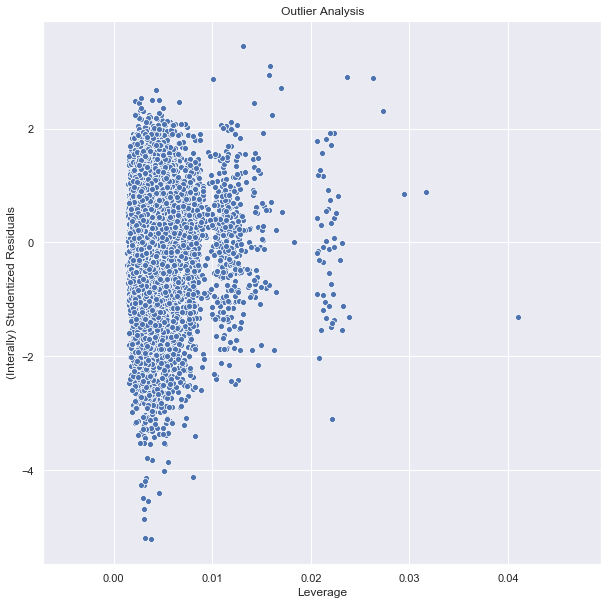

In [80]:
# Scatter Plot of the Leverage and Influence
influence_obj = OLSInfluence(results)

student_resids = influence_obj.resid_studentized
leverage = influence_obj.hat_matrix_diag

fig, ax = plt.subplots(figsize = (10, 10))
sns.scatterplot(leverage, student_resids, ax = ax)
ax.set_xlabel('Leverage')
ax.set_ylabel('(Interally) Studentized Residuals')
ax.set_title('Outlier Analysis')
fig.savefig('outlier-analysis.png')
fig

In [81]:
# Cooks distance
cooks, pvals = influence_obj.cooks_distance

# p-values are all 1, indicative of no outliers
pd.Series(pvals).describe()

count    1.251300e+04
mean     1.000000e+00
std      1.110223e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [82]:
# The maximum is tiny.
#  1 is considered a cutoff for the cooks distance
#   which asymptotically follows an F dist
cooks.max()

0.004022923172831934

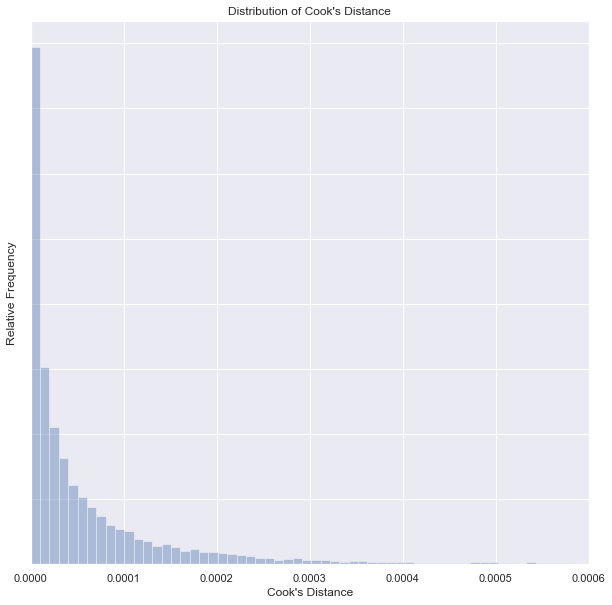

In [83]:
# Here is plot of the distribution
fig, ax = plt.subplots(figsize = (10, 10))
sns.distplot(cooks, kde = False, ax = ax, bins = 400)
ax.set_xlim([0, 0.0006])
ax.set_xlabel('''Cook's Distance''')
ax.set_yticklabels([])
ax.set_title('''Distribution of Cook's Distance''')
ax.set_ylabel('Relative Frequency')
fig.savefig('cooks-distance.png')
fig

# Part 5: Interpretation

In [84]:
# Un-transform the y variable to allow interpretation
model.restore_state('remove multicollinearity')
plt.close('all')

In [85]:
def is_bad_interaction(col_name):
    return bool(re.search(''':C\(highest_education\)\[A Level or Equivalent\]''', col_name))

In [86]:
X = design_matrix(model.regress(df))

In [87]:
lfilter(is_bad_interaction, X.columns)

['C(code_module)[T.BBB]:C(highest_education)[A Level or Equivalent]',
 'C(code_module)[T.CCC]:C(highest_education)[A Level or Equivalent]',
 'C(code_module)[T.DDD]:C(highest_education)[A Level or Equivalent]',
 'C(code_module)[T.EEE]:C(highest_education)[A Level or Equivalent]',
 'C(code_module)[T.FFF]:C(highest_education)[A Level or Equivalent]']

In [88]:
drop_col(X, *filter(is_bad_interaction, X.columns))

In [89]:
results = sm.OLS(df[model.y].values, X, hasconst = True).fit()

In [90]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     68.38
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:58:32   Log-Likelihood:                -48679.
No. Observations:               12513   AIC:                         9.746e+04
Df Residuals:                   12462   BIC:                         9.784e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           64.6008      1.031     62.668      0.000      62.580      66.621
C(disability)[T.Y]                                                  -1.5992      0.421     -3.803      0.000      -2.423      -0.775
C(highest_education)[T.Lower than A Level]                          -1.4200      1.318     -1.078      0.281      -4.003       1.163
C(highest_education)[T.Some College or More]                         1.4140      1.209      1.170      0.242      -0.956       3.784
C(age_band)[T.35+]                                                   0.3904      1.034      0.378      0.706      -1.636       2.417
C(class_)[T.AAAJ2014]                                               -0.4289      1.012     -0.424      0.672      -2.412       1.554
C(class_)[T.BBBB2013]                                                9.5364      1.161      8.215      0.000       7.261      11.812
C(class_)[T.BBBB2014]                                                8.7079      1.169      7.451      0.000       6.417      10.999
C(class_)[T.BBBJ2013]                                                8.2937      1.124      7.379      0.000       6.090      10.497
C(class_)[T.BBBJ2014]                                                2.4060      1.092      2.203      0.028       0.265       4.547
C(class_)[T.CCCB2014]                                                8.7283      1.217      7.170      0.000       6.342      11.114
C(class_)[T.CCCJ2014]                                               10.6055      1.174      9.033      0.000       8.304      12.907
C(class_)[T.DDDB2013]                                                0.4464      1.286      0.347      0.729      -2.075       2.968
C(class_)[T.DDDB2014]                                                1.1118      1.209      0.920      0.358      -1.258       3.481
C(class_)[T.DDDJ2013]                                                0.7918      1.145      0.692      0.489      -1.452       3.036
C(class_)[T.DDDJ2014]                                                2.8449      1.138      2.499      0.012       0.614       5.076
C(class_)[T.EEEB2014]                                                8.0952      1.266      6.393      0.000       5.613      10.577
C(class_)[T.EEEJ2013]                                                8.7857      1.199      7.327      0.000       6.435      11.136
C(class_)[T.EEEJ2014]                                               10.7935      1.187      9.093      0.000       8.467      13.120
C(class_)[T.FFFB2013]                                                8.3888      1.128      7.439      0.000       6.178      10.599
C(class_)[T.FFFB2014]   

In [91]:
sm.stats.anova_lm(model.regress(df), typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(disability),1.0,6.520619e+03,6520.619474,46.339829,1.039788e-11
C(highest_education),2.0,4.450683e+04,22253.413334,158.147454,1.494749e-68
C(age_band),1.0,3.450691e+03,3450.691255,24.522891,7.439428e-07
C(class_),18.0,1.886303e+05,10479.459898,74.473964,1.518902e-259
C(code_module):C(highest_education),15.0,7.746275e+03,516.418303,3.670010,1.815421e-06
C(code_module):C(age_band),5.0,3.421448e+03,684.289584,4.863014,1.905858e-04
imd_band,1.0,2.073294e+04,20732.944831,147.342000,1.023712e-33
num_of_prev_attempts,1.0,1.715564e+04,17155.639017,121.919302,3.248948e-28
activity_skew,1.0,4.149257e+02,414.925706,2.948736,8.596959e-02
clicks_externalquiz,1.0,2.204710e+04,22047.101793,156.681268,9.853868e-36


In [92]:
with open('regression-table.csv', 'w') as f:
    f.write(results.summary().as_csv())
    
anova = sm.stats.anova_lm(model.regress(df), typ = 1)
anova.to_csv('anova.csv')

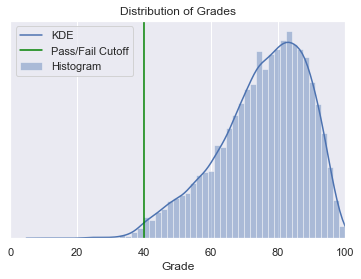

In [93]:
fig, ax = plt.subplots()
sns.distplot(df[model.y], ax = ax,
             hist_kws = {'label' : 'Histogram'},
             kde_kws  = {'label' : 'KDE'})
ax.set_xlabel('Grade')
ax.set_ylabel('')
ax.set_title('Distribution of Grades')
ax.set_xlim([0, 100])
ax.set_yticks([])
ax.axvline(40, color = 'green', label = 'Pass/Fail Cutoff')
ax.legend();
fig.savefig('y-dist.png', transparent=True)

fig

In [94]:
df[model.y].describe()

count    12513.000000
mean        75.393726
std         13.364267
min         11.200000
25%         67.270000
50%         77.440000
75%         85.720000
max        100.000000
Name: grade_Assessment, dtype: float64

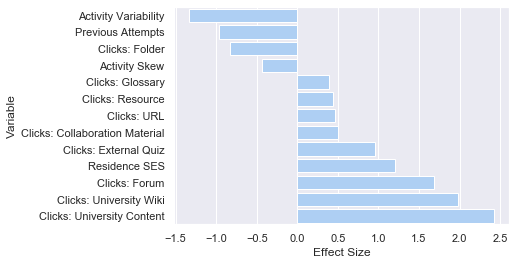

In [95]:
# Build the regression table for the continuous variables
#  Effect size is coefficient times standard deviation of the covariate
# Then plot the effect sizes

coeffs        = results.params[model.X_cont]
coeffs.name   = 'coefficient'
summary_stats = df[coeffs.index].describe().transpose()
effect_size_table = summary_stats.join(coeffs)

effect_size_table['effect_size'] = effect_size_table['std'] * effect_size_table.coefficient
effect_size_table.rename(index = var_name_dict, inplace = True)
effect_size_table = effect_size_table.sort_values('effect_size').reset_index()

fig, ax = plt.subplots()
sns.barplot(y = 'index', x = 'effect_size', data = effect_size_table.sort_values('effect_size').reset_index(),
            ci = None, color = sns.xkcd_rgb['baby blue'], ax = ax)
ax.set_ylabel('Variable')
ax.set_xlabel('Effect Size')
fig.savefig('effect-size.svg')
fig

# Possible Further Steps

## Modeling

See presentation

## Software

The 'model' class developed in utilities.py is very helpful by letting us keep track of what is in and out of our model at any given time. Future enhancements could include:
- Stronger support for interactions
- Internalizing many of the common tasks used here (correlation matricies, backwards stepwise regression, distribution plots, residual plots, qqplots, etc.)